# Imports

In [1]:
from modules.data import  data_reader, data_loader
from modules.sr import result_saver
from modules.models import lag_llama
from modules.experiment.tscv import get_tscv_results, get_summary, extract_metrics
from modules.visualization import graphs
from modules.fine_tuning import lag_llama_ft
from modules.models import prophet


In [2]:
"""
import os
print(os.getcwd())
"""

'\nimport os\nprint(os.getcwd())\n'

In [3]:
"""
from datetime import datetime

# Get the current date and time
current_datetime = datetime.now()

# Format the date and time as a string
datetime_str = current_datetime.strftime("%Y-%d-%m %H:%M:%S")

# Return the date and time as a string
NOW = datetime_str
"""

'\nfrom datetime import datetime\n\n# Get the current date and time\ncurrent_datetime = datetime.now()\n\n# Format the date and time as a string\ndatetime_str = current_datetime.strftime("%Y-%d-%m %H:%M:%S")\n\n# Return the date and time as a string\nNOW = datetime_str\n'

# Parameters

In [4]:
# experiment parameters
#constraint: FOLDS x PREDICTION_LENGTH + TRAIN_SIZE !!must not!! be bigger than len(data)

PREDICTION_LENGTH = 1 # currentlz only works for PREDICTION_LENGTH > 1
TICKER = "S&P 500"
FREQUENCY = "minutely" # currently we only have dailz frequency
TYPE_OF_DATA = "stock" # currently we only have stock prices saved
MODELS = ["arima", "llama", "autoregressor", "fine-tuned Llama"] # currentlz works onlz for these two
FOLDS = 5 # for TSCV # reduced to two for testing purposes
CONTEXT_LENGTH = 245 # set to 245 for testing purposes
METRICS = ['r2', 'mse', 'mae', 'rmse', 'mda', "mape"]

# fine-tuning parameters
BATCH_SIZE = 10
MAX_EPOCHS = 5

# data parameters
START_DATE = "2024-07-22"
END_DATE = "2024-07-27"

# want to add
#TRAIN_PERIOD = # context lenghts. Should take a look into this
TRAIN_SIZE = CONTEXT_LENGTH



# Data

In [5]:
"""
data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY)
# this is just in case there are more CSVs of the same type and frequency, the data should be the first in the list
#if len(data) > 1:
data = data[0]

simple_data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY, match = ["simple"])
#if len(simple_data) > 1:
simple_data = simple_data[0]

train_data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY, match = ["train"])
train_data = train_data[0]

test_data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY, match = ["test"])
test_data = test_data[0]
"""

'\ndata = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY)\n# this is just in case there are more CSVs of the same type and frequency, the data should be the first in the list\n#if len(data) > 1:\ndata = data[0]\n\nsimple_data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY, match = ["simple"])\n#if len(simple_data) > 1:\nsimple_data = simple_data[0]\n\ntrain_data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY, match = ["train"])\ntrain_data = train_data[0]\n\ntest_data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY, match = ["test"])\ntest_data = test_data[0]\n'

In [6]:
DATA_CONFIG = {"ticker" : TICKER,
               "frequency" : FREQUENCY,
               "start" : START_DATE,
               "end" : END_DATE}



In [7]:
data = data_loader.get_data(data_type=TYPE_OF_DATA, kwargs=DATA_CONFIG)

[*********************100%%**********************]  1 of 1 completed


# Additional parameters

In [8]:
DATA_LENGTH = len(data)
FOLDS = int((DATA_LENGTH - TRAIN_SIZE) / PREDICTION_LENGTH) # this calculates max ammount of folds we can have given a set TRAIN_SIZE and PREDICTION_LENGTH
FOLDS = 5


# Fine tuning

In [9]:
#preparing the training data for lag llama fine tuning
ft_train_data = lag_llama.prepare_data(data=ft_data, 
                                       prediction_length=0, 
                                       frequency=FREQUENCY)

In [10]:
# creating the lag llama predictor object 
predictor = lag_llama_ft.get_predictor(prediction_length=PREDICTION_LENGTH, 
                                       context_length=CONTEXT_LENGTH, 
                                       batch_size=BATCH_SIZE, 
                                       max_epochs=MAX_EPOCHS)

In [ ]:
# fine-tuning the predictor object
predictor = predictor.train(ft_train_data, 
                            cache_data = True, 
                            shuffle_buffer_length = 1000)

In [ ]:
r, p = get_tscv_results(data = data,
                           prediction_horizon=PREDICTION_LENGTH,
                           context_length=CONTEXT_LENGTH, 
                           folds=FOLDS, 
                           frequency=FREQUENCY,
                           predictor=predictor)

# Saving results

In [34]:
r

,r2,mse,mae,rmse,mda,mape
arima,0.450407,14.482253,3.190176,3.805556,0.6,0.014594
lag_llama,-58.940031,1579.470616,38.714596,39.742554,0.2,0.176560
autoregressor,0.447312,14.563802,3.341670,3.816255,0.6,0.015282
ft_lag_llama,-0.700098,44.799023,5.472705,6.693207,0.6,0.025150


In [35]:
p

,arima,lag_llama,autoregressor,ft_lag_llama,actual
0,213.656341,178.009499,213.250000,218.587265,214.100006
1,214.125477,188.782514,214.100006,215.746447,210.619995
2,210.232611,177.785137,210.619995,203.581973,216.750000
3,217.310340,176.589256,216.750000,217.426447,220.270004
4,220.542241,181.412634,220.270004,220.673695,221.550003
5,221.632904,174.763386,221.550003,220.005372,226.339996


In [18]:
experiment_name = f"PREDICTION_LENGTH={PREDICTION_LENGTH}__TICKER={TICKER}__FREQUENCY={FREQUENCY}__TYPE_OF_DATA={TYPE_OF_DATA}__FOLDS={FOLDS}__CONTEXT_LENGTH/TRAIN_SIZE={CONTEXT_LENGTH}__FT_START_DATE={FT_START_DATE}__START_DATE={START_DATE}__END_DATE={END_DATE}__FT_LENGTH={FT_LENGTH}__DATA_LENGTH={DATA_LENGTH}" 

In [27]:
experiment_name = f"P_L={PREDICTION_LENGTH}__T={TICKER}__FR={FREQUENCY}__T_O_D={TYPE_OF_DATA}__FO={FOLDS}__C_L_T_S={CONTEXT_LENGTH}__FT_S_D={FT_START_DATE}__S_D={START_DATE}__E_D={END_DATE}__FT_L={FT_LENGTH}__D_L={DATA_LENGTH}.csv"

In [28]:
experiment_name

'P_L=1__T=AAPL__FR=daily__T_O_D=stock__FO=6__C_L_T_S=245__FT_S_D=2022-07-07__S_D=2023-07-07__E_D=2024-07-07__FT_L=251__D_L=251.csv'

In [29]:
result_saver.save_results(r, experiment_name, type="evaluation")
result_saver.save_results(p, experiment_name, type="prediction")

Data has been written to 'c:\Users\topco\Dokumenti\MSc Banking and Digital Finance UCL\Modules\Dissertation\MSc_dissertation\results\evaluation\P_L=1__T=AAPL__FR=daily__T_O_D=stock__FO=6__C_L_T_S=245__FT_S_D=2022-07-07__S_D=2023-07-07__E_D=2024-07-07__FT_L=251__D_L=251.csv'.
Data has been written to 'c:\Users\topco\Dokumenti\MSc Banking and Digital Finance UCL\Modules\Dissertation\MSc_dissertation\results\prediction\P_L=1__T=AAPL__FR=daily__T_O_D=stock__FO=6__C_L_T_S=245__FT_S_D=2022-07-07__S_D=2023-07-07__E_D=2024-07-07__FT_L=251__D_L=251.csv'.


# Models

In [ ]:
# arima


In [ ]:
# lag llama

# Fine tuning an estimator

In [12]:
PREDICTION_LENGTH = 5

In [13]:
#preparing the training data for lag llama fine tuning
ft_train_data = lag_llama.prepare_data(data=ft_data, 
                                       prediction_length=0, 
                                       frequency=FREQUENCY)

In [14]:
# creating the lag llama predictor object 
predictor = lag_llama_ft.get_predictor(prediction_length=PREDICTION_LENGTH, 
                                       context_length=CONTEXT_LENGTH, 
                                       batch_size=BATCH_SIZE, 
                                       max_epochs=MAX_EPOCHS)

In [15]:
# fine-tuning the predictor object
predictor = predictor.train(ft_train_data, 
                            cache_data = True, 
                            shuffle_buffer_length = 1000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\topco\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 4.13630 (best 4.13630), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Finance UCL\\Modules\\Dissertation\\MSc_dissertation\\lightning_logs\\version_31\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 3.42045 (best 3.42045), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Finance UCL\\Modules\\Dissertation\\MSc_dissertation\\lightning_logs\\version_31\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 2.96029 (best 2.96029), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Finance UCL\\Modules\\Dissertation\\MSc_dissertation\\lightning_logs\\version_31\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 2.73350 (best 2.73350), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Finance UCL\\Modules\\Dissertation\\MSc_dissertation\\lig

# SKLearn TSCV

In [16]:
r, p, a = get_tscv_results(data = data,
                           prediction_horizon=PREDICTION_LENGTH,
                           context_length=CONTEXT_LENGTH, 
                           folds=FOLDS, 
                           frequency=FREQUENCY, 
                           predictor=predictor)

Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]

Fold 1/5 finished in: 33.59 seconds
Prediction from   2024-05-30 00:00:00   until   2024-06-05 00:00:00
----------------------


Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]

Fold 2/5 finished in: 36.37 seconds
Prediction from   2024-06-06 00:00:00   until   2024-06-12 00:00:00
----------------------


Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]

Fold 3/5 finished in: 37.23 seconds
Prediction from   2024-06-13 00:00:00   until   2024-06-20 00:00:00
----------------------


Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]

Fold 4/5 finished in: 42.99 seconds
Prediction from   2024-06-21 00:00:00   until   2024-06-27 00:00:00
----------------------


C:\Users\topco\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]

Fold 5/5 finished in: 39.96 seconds
Prediction from   2024-06-28 00:00:00   until   2024-07-05 00:00:00
----------------------


In [17]:
#creating the summary for each model
s = [get_summary(r[i]) for i in range(len(r))]

In [18]:
means_df, medians_df, stds_df = extract_metrics(s, MODELS)

In [22]:
means_df

,r2,mse,mae,rmse,mda,mape
arima,-1.124579,33.290683,4.139551,5.099569,0.20,0.019661
llama,-130.505382,1141.032279,30.978688,32.462579,0.48,0.146769
autoregressor,-1.105772,33.202072,4.170400,5.075507,0.00,0.019808
fine-tuned Llama,-3.717170,59.233437,5.947423,7.108499,0.52,0.028609


# Visualisation

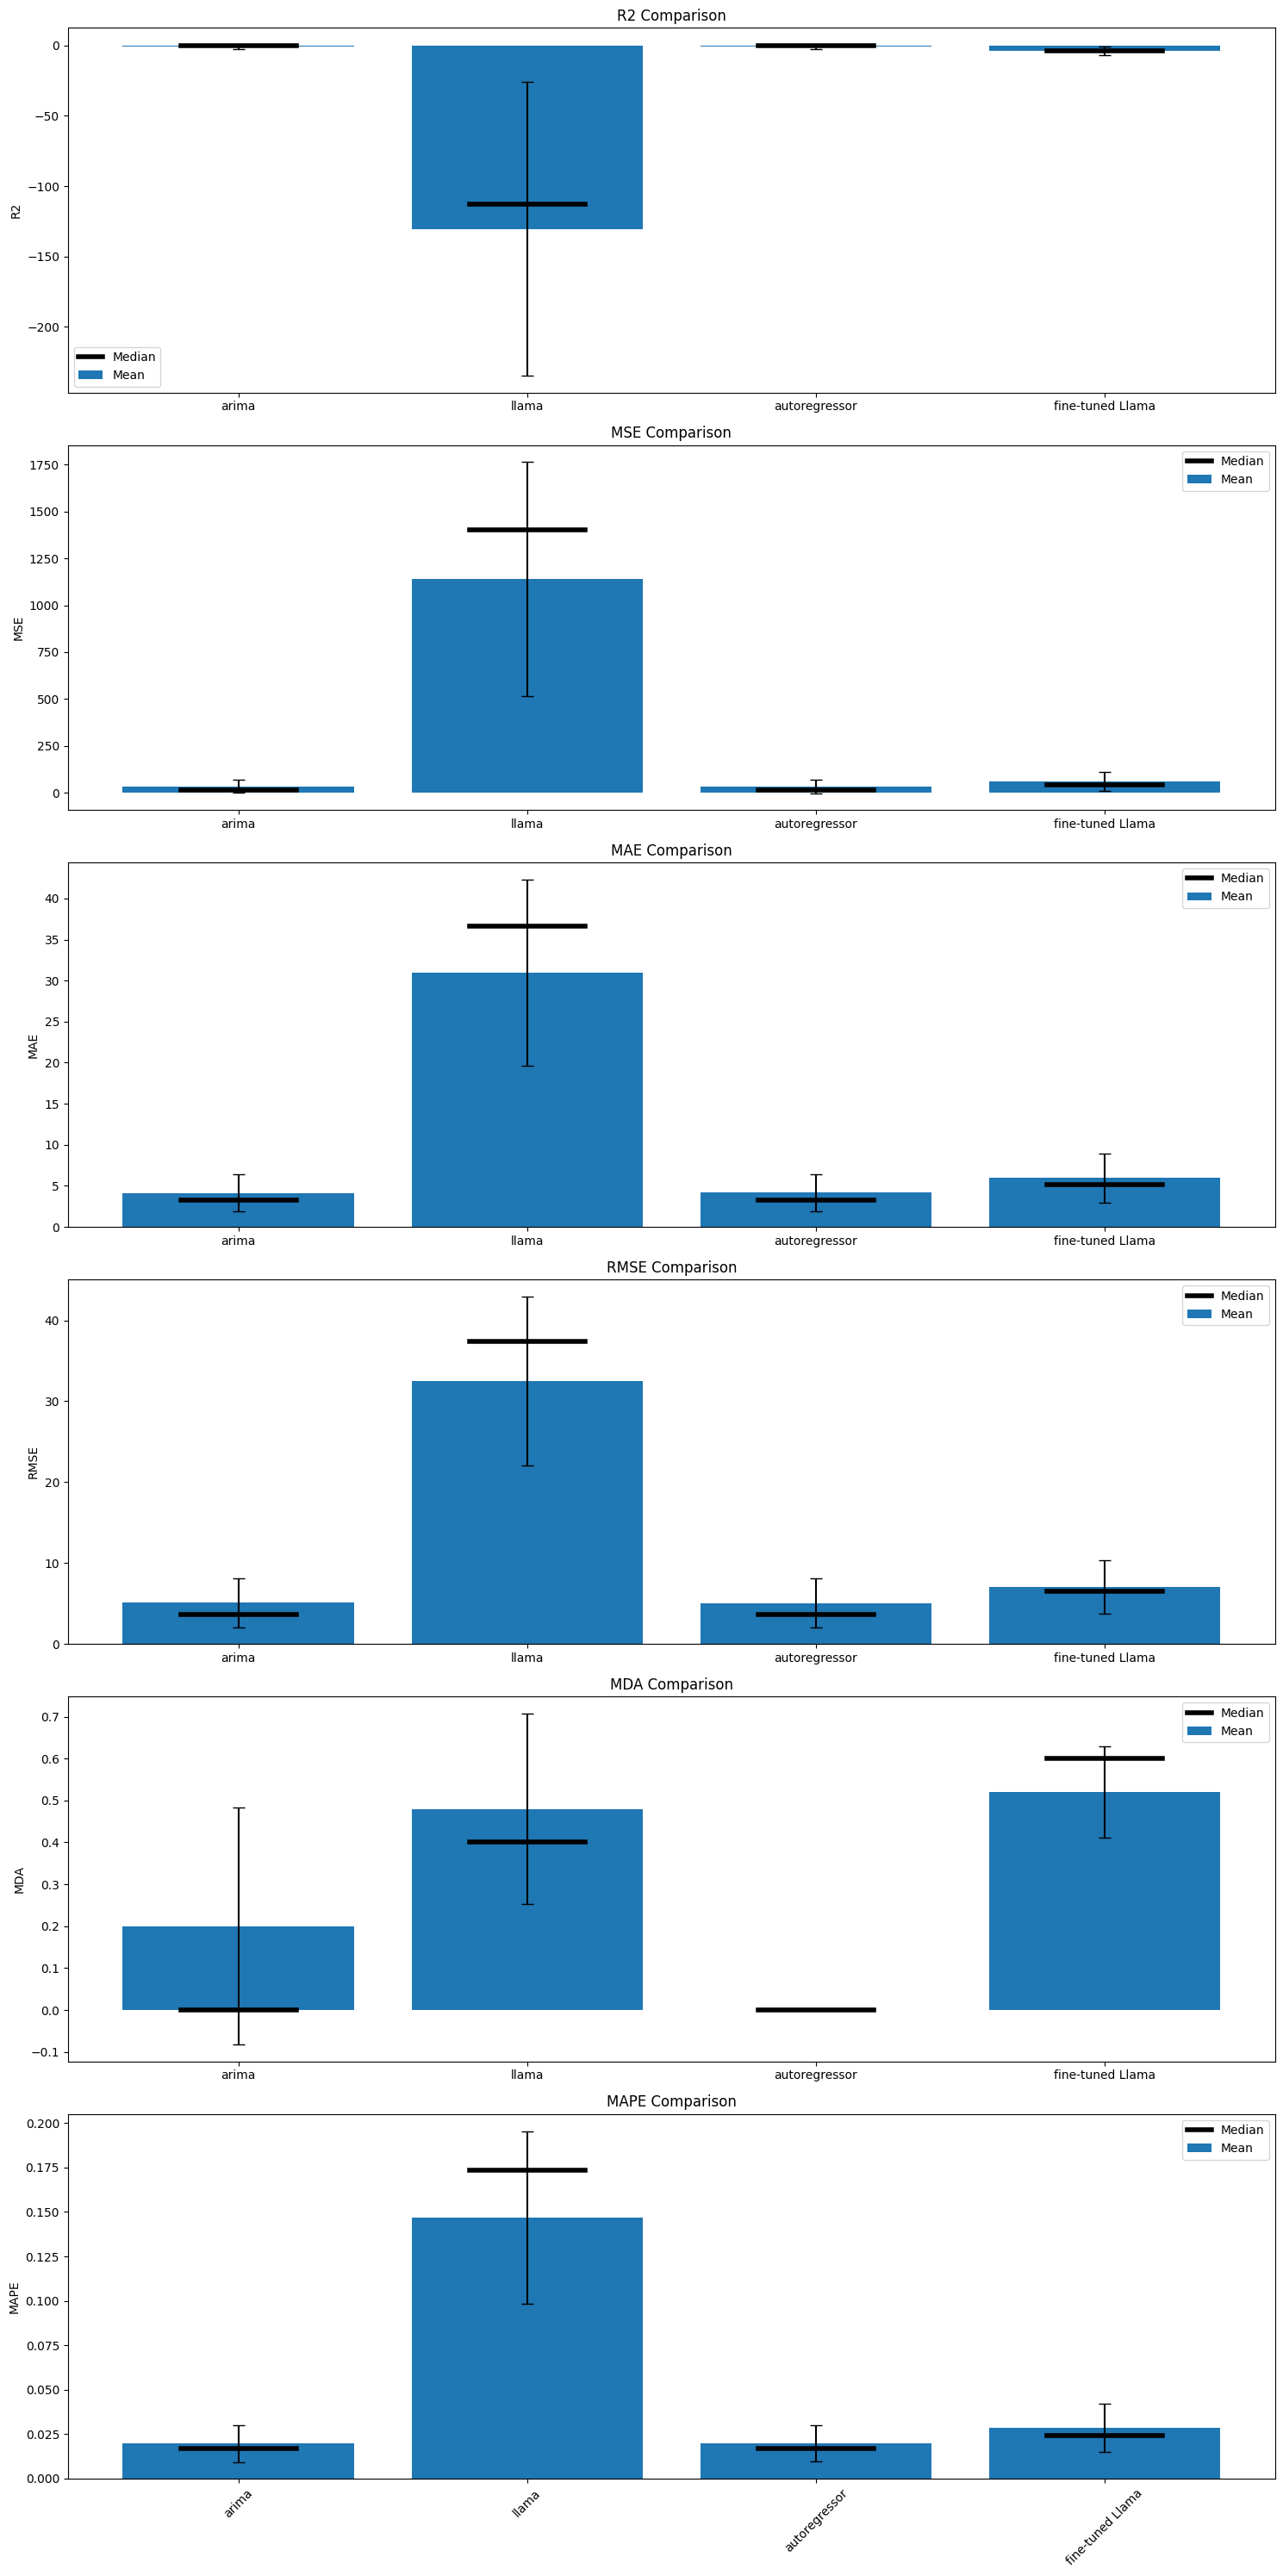

In [19]:
graphs.standard_visualisation(MODELS, METRICS, s)

In [20]:
graphs.interactive_visualisation(MODELS, METRICS, s)

In [21]:
graphs.prediction_visualisation(MODELS, p, a)

LABEL the graph
label the axes with timestamps
show the history of the actual
table of comparison, not just graph